In [35]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import gzip
import os
import warnings
import random
import graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization
from graphviz import Digraph

%matplotlib inline

In [36]:
df = pd.read_csv("./merge_result.csv")
print(df.info())
df = df.loc[df['is_defunct'].notnull()]

test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]', 'Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan',  'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air', 'tigerair australia', 'Air Madagascar', 'Southwest Airlines', 'Nouvel Air Tunise', 'TAROM', 'Wings Air', 'British Airways']
test = df[df['companyName'].isin(test_company)]
train = df[~df['companyName'].isin(test_company)]
y_train = train['is_defunct']
X_train = train.drop(columns=['is_defunct'])
y_test = test['is_defunct']
X_test = test.drop(columns=['is_defunct'])

features = list(X_train.columns)
del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
for col in del_cols:
    features.remove(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21541 entries, 0 to 21540
Columns: 176 entries, companyName to entertainment_rp
dtypes: float64(167), int64(1), object(8)
memory usage: 28.9+ MB
None


In [37]:
param = { #修改过的
    "boosting": "gbdt",
    'objective':'binary',
    'scale_pos_weight': 15,
    'metric': ('auc', 'binary_logloss'),
#     'metric': 'binary_logloss',
    'learning_rate': 0.001,
    'num_leaves': 6, # 6
    'min_data_in_leaf': 200, #120
    'max_depth': 5,                        
    "feature_fraction": 0.60279441778009675,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 0.94918097174380245 ,
    "bagging_seed": 11,
    "lambda_l1": 3.0031581969835157,
    "verbosity": -1,        
}

In [38]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
evals_result = {}  #记录训练结果所用

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx])

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    evals_result=evals_result,   #非常重要的参数,一定要明确设置
                    verbose_eval=500,
                    early_stopping_rounds=200
    )
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.138178	training's auc: 0.999021	valid_1's binary_logloss: 0.135879	valid_1's auc: 0.999315
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.127947	training's auc: 0.999898	valid_1's binary_logloss: 0.125947	valid_1's auc: 0.999879
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.135577	training's auc: 0.999596	valid_1's binary_logloss: 0.138281	valid_1's auc: 0.999367
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.148226	training's auc: 0.999596	valid_1's binary_logloss: 0.15202	valid_1's auc: 0.999367
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.136976	training's auc: 0.998936	valid_1's binary_logloss: 0.135162	valid_1's auc: 0.998728
[1000]	training's binary_logloss: 0.117035	training's auc: 0.999704	valid_1's binary_

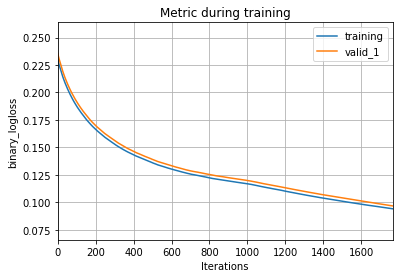

In [39]:
lgb.plot_metric(evals_result, metric='binary_logloss')#metric的值与之前的params里面的值对应

In [40]:
# lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应

In [41]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    print(thresholds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savepath:
        plt.savefig(savepath)
    plt.close(0)

[ 1.77052614  0.77052614  0.7703917  ...,  0.01247535  0.01245494
  0.0124207 ]


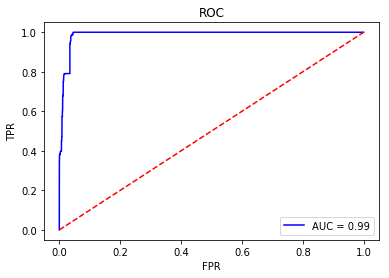

In [42]:
draw_ROC_curve(y_train, oof)

[ 1.18585783  0.18585783  0.18585058  0.18584176  0.18583796  0.18583452
  0.1858124   0.18580118  0.18578132  0.18577181  0.18563236  0.1847678
  0.18459918  0.16655919  0.16630553  0.15918686  0.15918316  0.15915368
  0.15911694  0.15909197  0.15905523  0.15731053  0.15725101  0.15719833
  0.15652088  0.15626194  0.13498481  0.13459758  0.13370384  0.13368447
  0.1262944   0.12627824  0.12627003  0.12626523  0.12624907  0.12624088
  0.12618706  0.12609081  0.12606662  0.12605046  0.12601312  0.12235682
  0.12140051  0.12130504  0.12124869  0.11887673  0.11885924  0.1181514
  0.1181034   0.11777859  0.11776135  0.11773665  0.11701064  0.11700292
  0.11699925  0.11698593  0.10591659  0.10590764  0.10590521  0.10589849
  0.10589626  0.10588955  0.10588711  0.10586378  0.10338352  0.09386614
  0.09307847  0.09201015  0.09127812  0.09123616  0.09118553  0.09114304
  0.09099239  0.09091983  0.09089247  0.09067515  0.09037376  0.09034524
  0.09033044  0.09032145  0.09016348  0.09009697  0.0

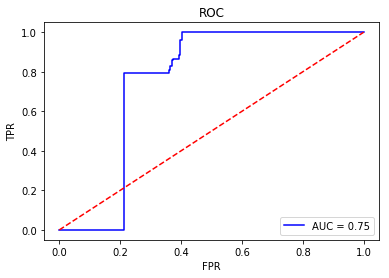

In [43]:
draw_ROC_curve(y_test, predictions)

In [44]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)
new_test_company = ['Primera Air [no longer operating]', 'Monarch [no longer operating]', 'WOW air [no longer operating]']
new_test = new_test[new_test['companyName'].isin(new_test_company)]

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']))

,mean,min,max
companyName,,,
Monarch [no longer operating],0.073795,0.071190,0.074337
Primera Air [no longer operating],0.049715,0.049169,0.050627
WOW air [no longer operating],0.075602,0.072757,0.075974


In [45]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

,mean,min,max
companyName,,,
Kuwait Airways,0.185752,0.183076,0.185858
Air Panama,0.160275,0.159055,0.166630
Kan Airlines,0.156770,0.156262,0.157311
Myanmar National Airlines,0.134456,0.133684,0.137981
Philippine Airlines (PAL),0.126182,0.125993,0.126294
Mauritania Airlines,0.120107,0.117856,0.122357
Cayman Airways,0.119425,0.116986,0.121401
Royal Jordanian,0.105861,0.103384,0.105917
Thomas Cook Airlines Scandinavia,0.092162,0.090227,0.093866
